## Importing Libraries

In [72]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [73]:
df = pd.read_csv('Heart Attack.csv')
df.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [74]:
df.dtypes

age                int64
gender             int64
impluse            int64
pressurehight      int64
pressurelow        int64
glucose          float64
kcm              float64
troponin         float64
class             object
dtype: object

In [75]:
df.describe()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


In [76]:
df.isnull().sum()

age              0
gender           0
impluse          0
pressurehight    0
pressurelow      0
glucose          0
kcm              0
troponin         0
class            0
dtype: int64

In [77]:
df[df.impluse > 1000]

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
63,45,1,1111,141,95,109.0,1.33,1.010,positive
717,70,0,1111,141,95,138.0,3.87,0.028,positive
1069,32,0,1111,141,95,82.0,2.66,0.008,negative


In [78]:
condition = df.impluse < 1000
df = df[condition]

In [79]:
df.shape

(1316, 9)

In [80]:
# Remove the outliers from troponin and kcm columns using z-score
z_scores = stats.zscore(df[['troponin', 'kcm']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

In [81]:
df.shape

(1253, 9)

In [82]:
df = pd.get_dummies(df, columns=['gender'])
df.rename(columns={'gender_0': 'female', 'gender_1': 'male'}, inplace=True)

df.head()

,age,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class,female,male
0,64,66,160,83,160.0,1.80,0.012,negative,0,1
1,21,94,98,46,296.0,6.75,1.060,positive,0,1
2,55,64,160,77,270.0,1.99,0.003,negative,0,1
3,64,70,120,55,270.0,13.87,0.122,positive,0,1
4,55,64,112,65,300.0,1.08,0.003,negative,0,1


In [83]:
df['class'] = df['class'].replace({'positive': 1, 'negative': 0})
df.rename(columns={'class': 'y'}, inplace=True)
df.head()

,age,impluse,pressurehight,pressurelow,glucose,kcm,troponin,y,female,male
0,64,66,160,83,160.0,1.80,0.012,0,0,1
1,21,94,98,46,296.0,6.75,1.060,1,0,1
2,55,64,160,77,270.0,1.99,0.003,0,0,1
3,64,70,120,55,270.0,13.87,0.122,1,0,1
4,55,64,112,65,300.0,1.08,0.003,0,0,1


In [84]:
# Apply log transformation to the columns with skewed data
df['glucose'] = np.log1p(df['glucose'])
df['kcm'] = np.log1p(df['kcm'])
df['troponin'] = np.log1p(df['troponin'])

In [85]:
X = df.drop('y', axis=1)
y = df['y']

In [86]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Model Building

In [87]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1002, 9), (251, 9), (1002,), (251,))

In [158]:
INPUT_SHAPE = x_train.shape[1]
OUTPUT_SHAPE = 1
LR = 0.001
EPOCHS = 300
BATCH_SIZE = 16

In [159]:
model = Sequential([
    tf.keras.Input(shape=(INPUT_SHAPE,)),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(OUTPUT_SHAPE, activation='sigmoid')]
)

model.compile(loss=BinaryCrossentropy(), optimizer=Adam(
    learning_rate=LR), metrics=['accuracy'])

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 16)                160       
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_81 (Dense)            (None, 8)                 136       
                                                                 
 dense_82 (Dense)            (None, 1)                 9         
                                                                 
Total params: 305 (1.19 KB)
Trainable params: 305 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [160]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0,
                              mode='min', restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, validation_data=(x_test, y_test), callbacks=[earlyStopping], verbose=1, shuffle=True)

Epoch 1/300


63/63 [==============================] - 1s 6ms/step - loss: 0.7000 - accuracy: 0.5499 - val_loss: 0.6447 - val_accuracy: 0.6135
Epoch 2/300
63/63 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6188 - val_loss: 0.6070 - val_accuracy: 0.6653
Epoch 3/300
63/63 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6507 - val_loss: 0.5737 - val_accuracy: 0.7052
Epoch 4/300
63/63 [==============================] - 0s 3ms/step - loss: 0.5797 - accuracy: 0.6826 - val_loss: 0.5398 - val_accuracy: 0.7490
Epoch 5/300
63/63 [==============================] - 0s 3ms/step - loss: 0.5466 - accuracy: 0.7066 - val_loss: 0.5095 - val_accuracy: 0.7410
Epoch 6/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5141 - accuracy: 0.7395 - val_loss: 0.4783 - val_accuracy: 0.7490
Epoch 7/300
63/63 [==============================] - 0s 4ms/step - loss: 0.4919 - accuracy: 0.7395 - val_loss: 0.4528 - val_accuracy: 0.7689
Epoch 8/300
63/63 [======

In [164]:
# Calculate the accuracy of the model on the test set
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.0976 - accuracy: 0.9721


[0.09763945639133453, 0.9721115827560425]

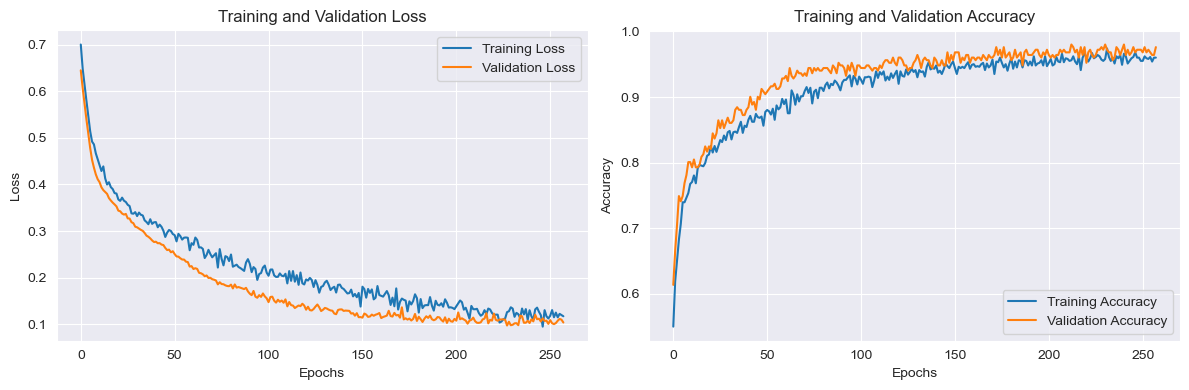

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# Extract training and validation metrics from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig('loss_accuracy.png', dpi=300)
plt.show()

8/8 [==============================] - 0s 2ms/step


C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_2436\3117606781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['', 'Negative', 'Positive'])
C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_2436\3117606781.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['', 'Negative', 'Positive'])


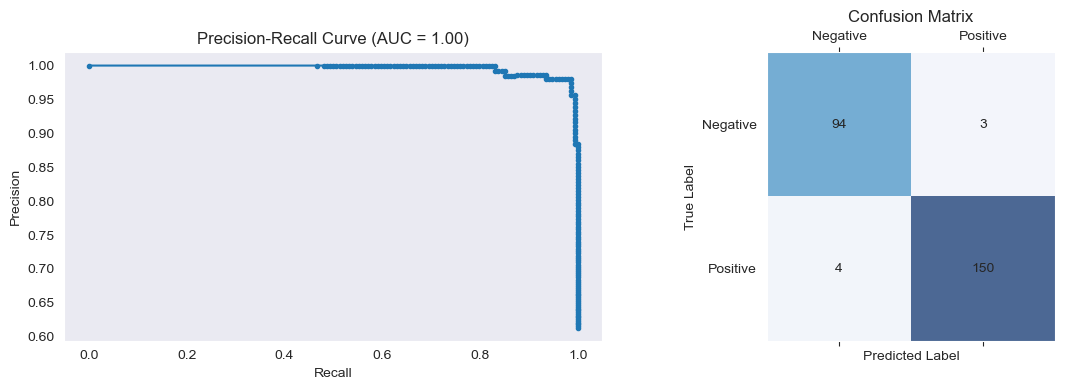

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.96        97
     Class 1       0.98      0.97      0.98       154

    accuracy                           0.97       251
   macro avg       0.97      0.97      0.97       251
weighted avg       0.97      0.97      0.97       251

Precision at Best Threshold: 0.9806
Recall at Best Threshold: 0.9870
F1-Score at Best Threshold: 0.9838


In [170]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

sns.set_style('dark')

# Make predictions on the validation data
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)

# Calculate precision and recall
precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate the area under the curve (AUC) for precision-recall
pr_auc = auc(recall, precision)

# Print classification report
class_report = classification_report(
    y_test, y_pred_binary, target_names=['Class 0', 'Class 1'])

# Create subplots for precision-recall curve and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot precision-recall curve
ax1.plot(recall, precision, marker='.')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')

# Plot confusion matrix
ax2.matshow(confusion, cmap=plt.cm.Blues, alpha=0.7)
for i in range(2):
    for j in range(2):
        ax2.text(j, i, str(confusion[i, j]), va='center', ha='center')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_xticklabels(['', 'Negative', 'Positive'])
ax2.set_yticklabels(['', 'Negative', 'Positive'])
ax2.set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig('pr_curve_confusion_matrix.png', dpi=300)
plt.show()

# Print the classification report
print("Classification Report:")
print(class_report)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)
# Find the threshold that maximizes F1-score
best_f1_index = np.argmax(f1_score)

# Print precision, recall, and F1-score at the threshold that maximizes F1-score
print(f"Precision at Best Threshold: {precision[best_f1_index]:.4f}")
print(f"Recall at Best Threshold: {recall[best_f1_index]:.4f}")
print(f"F1-Score at Best Threshold: {f1_score[best_f1_index]:.4f}")

In [171]:
# save the keras model
model.save('heart_attack_model.keras')